# Modeling Extremes - From Scratch

In [1]:
import autoroot
import pandas as pd
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import seaborn as sns
import numpy as np
import regionmask
from pyextremes import get_extremes, get_return_periods
from pyextremes.plotting import plot_extremes
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

In [2]:
from bayesevt._src.data.local import DATASET_SPAIN_ANOMALIES

data_dir = DATASET_SPAIN_ANOMALIES["t2max"]
data_dir = '/pool/datos/reanalisis/era5/hourly/europe/025/t2m/*.nc'

ds = xr.open_mfdataset(data_dir).isel(expver=0)

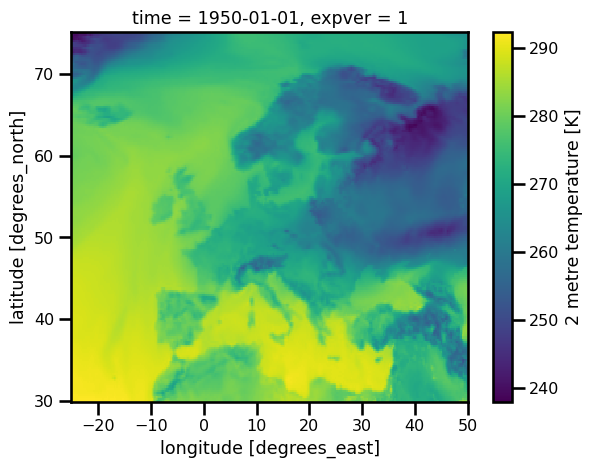

In [3]:
ds.t2m.isel(time=0).plot.pcolormesh()

## Masking

In [4]:
from bayesevt._src.geoprocessing.masks import add_country_mask, add_land_mask


In [5]:
ds = add_country_mask(ds, country="Spain")
ds = add_land_mask(ds)

In [6]:
ds

<xarray.Dataset> Size: 139GB
Dimensions:     (longitude: 301, latitude: 181, time: 639912)
Coordinates:
  * longitude   (longitude) float32 1kB -25.0 -24.75 -24.5 ... 49.5 49.75 50.0
  * latitude    (latitude) float32 724B 75.0 74.75 74.5 ... 30.5 30.25 30.0
  * time        (time) datetime64[ns] 5MB 1950-01-01 ... 2022-12-31T23:00:00
    expver      int32 4B 1
    region      int64 8B 132
    abbrevs     <U3 12B 'E'
    names       <U16 64B 'Spain'
Data variables:
    t2m         (time, latitude, longitude) float32 139GB dask.array<chunksize=(8760, 181, 301), meta=np.ndarray>
    spain_mask  (latitude, longitude) int16 109kB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
    land_mask   (latitude, longitude) int16 109kB 1 1 1 1 1 1 1 ... 0 0 0 0 0 0
Attributes:
    Conventions:  CF-1.6
    history:      2023-02-03 14:44:20 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

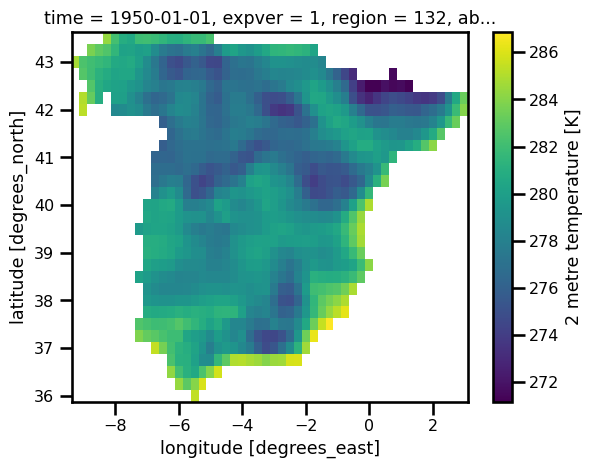

In [7]:

ds.where(ds.spain_mask==1, drop=True).isel(time=0).t2m.plot()

## Clean Data

* Take Weighted Mean
* Convert Kelvin to Celsius
* Convert to DataFrame & Series
* Drop NANS
* Sort according to time
* Small Correction to Date

In [8]:
# # take weighted spatial mean
# import numpy as np
# weights = spain_mask.squeeze() * np.cos(np.deg2rad(ds.latitude))
# ds = xr.open_mfdataset(data_url)
# data = ds.weighted(weights).mean(dim=["latitude", "longitude"]) - 272.15

### Region Selection

We are going to select Spain but also perhaps Madrid.

In [9]:
# # take weighted spatial mean
# weights = ds["spain_mask"] * np.cos(np.deg2rad(ds.latitude))
# data = ds.weighted(weights).mean(dim=["latitude", "longitude"])

# select MADRID region
data = ds.sel(longitude=-3.703790, latitude=40.416775, method="nearest")

In [10]:

# # convert Kelvin to Celcius
data -= 272.15
# convert to dataframe
data = data.t2m.to_dataframe()
# create time series
data = pd.Series(data["t2m"])
# remove nans
data = data.dropna()
# sort ascending
data = data.sort_index(ascending=True)
# # start time
t0 = data.index[0]
# # rescale time
data = data - (data.index.array - pd.to_datetime(t0.year)) / pd.to_timedelta("365.2425D") * 2.87e-3
# data.describe()

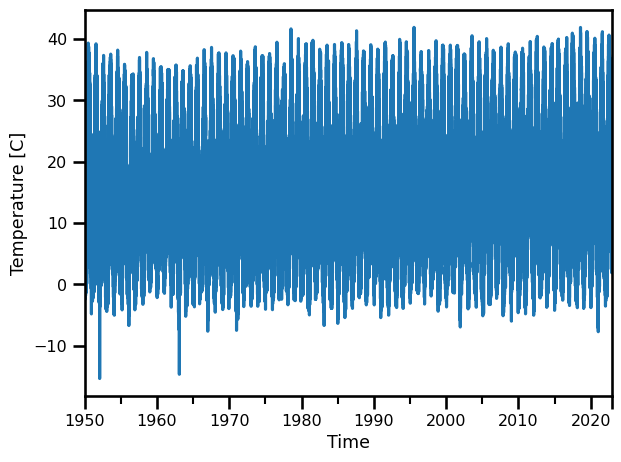

In [11]:
fig, ax = plt.subplots()

data.plot(ax=ax)

ax.set(
    xlabel="Time",
    ylabel="Temperature [C]"
)
plt.tight_layout()
plt.show()

## Extremes

In [17]:
extremes_method = "BM" # 
block_size = "365.2425D" # f"{3*30}D" # 
extremes_type = "high"
extremes = get_extremes(
    data, 
    method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
    
)

/home/juanjohn/miniconda/envs/bayesevt_ai/lib/python3.10/site-packages/pyextremes/extremes/peaks_over_threshold.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  r = pd.to_timedelta(r)


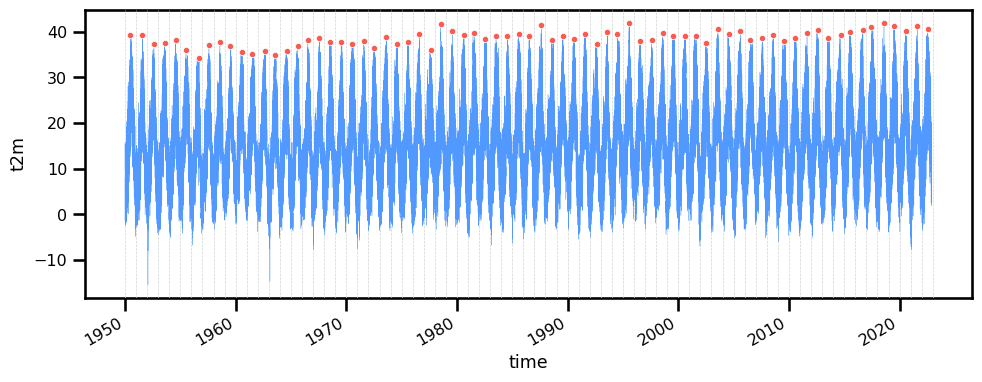

In [18]:
fig, ax = plt.subplots(figsize=(10,4))

plot_extremes(
    ax=ax,
    ts=data,
    extremes=extremes,
    extremes_method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

plt.tight_layout()
plt.show()

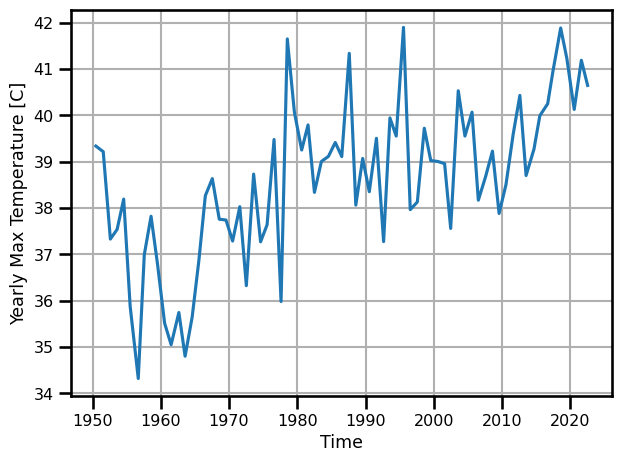

In [19]:
fig, ax = plt.subplots()

ax.plot(extremes)
ax.set(
    xlabel="Time",
    ylabel="Yearly Max Temperature [C]"
)
plt.grid(which="both", visible=True)
plt.tight_layout()
plt.show()

In [25]:
threshold = np.quantile(data.values, q=0.98)
threshold = 34.0

In [26]:
extremes_method = "POT" # "BM" # 
extremes_type = "high"

extremes = get_extremes(
    data, 
    method=extremes_method,
    extremes_type=extremes_type, 
    threshold=threshold
    
)
extremes.shape

/home/juanjohn/miniconda/envs/bayesevt_ai/lib/python3.10/site-packages/pyextremes/extremes/peaks_over_threshold.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  r = pd.to_timedelta(r)


(591,)

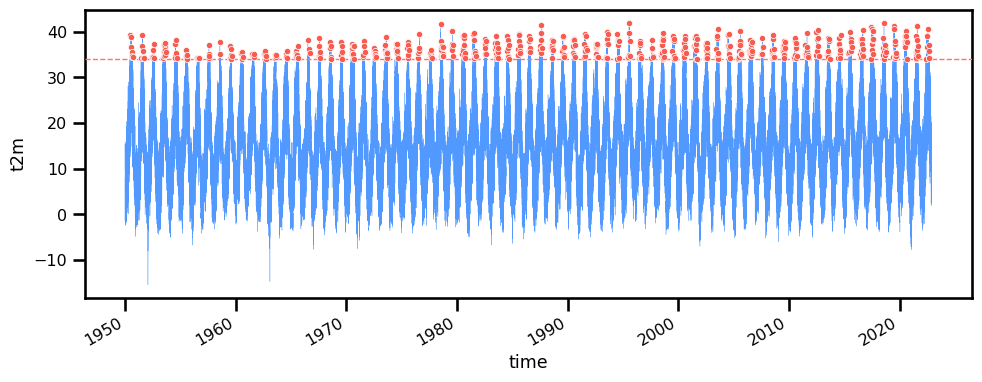

In [27]:
fig, ax = plt.subplots(figsize=(10,4))

plot_extremes(
    ax=ax,
    ts=data,
    extremes=extremes,
    extremes_method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

plt.tight_layout()
plt.show()

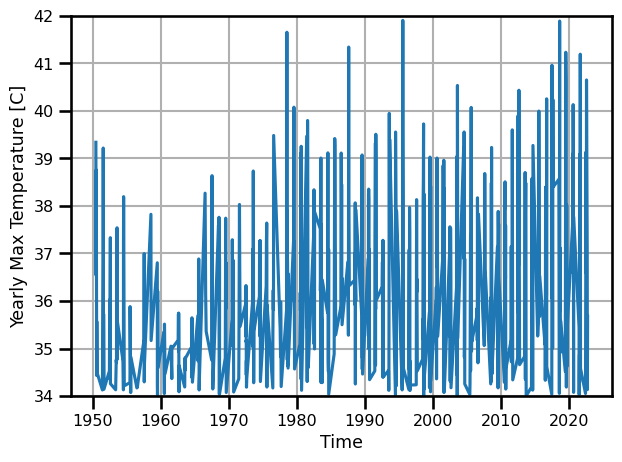

In [30]:
fig, ax = plt.subplots()

ax.plot(extremes)
ax.set(
    xlabel="Time",
    ylabel="Yearly Max Temperature [C]",
    ylim=[34, 42],
)
plt.grid(which="both", visible=True)
plt.tight_layout()
plt.show()

## Diagnostics

In [135]:
extremes_method = "BM" # 
block_size = "365.2425D" # f"{3*30}D" # 
extremes_type = "high"

return_periods = get_return_periods(
    ts=data,
    extremes=extremes,
    extremes_method=extremes_method,
    extremes_type=extremes_type,
    block_size=block_size,
    return_period_size=block_size,
    plotting_position="weibull",
)
# 
return_periods = return_periods.sort_values(by="return period", ascending=False)

In [139]:
extremes_method = "POT" # "BM" # 
extremes_type = "high"
threshold = np.quantile(data.values, q=0.95)
return_period_size = "365.2425D"

return_periods = get_return_periods(
    ts=data,
    extremes=extremes,
    extremes_method=extremes_method,
    extremes_type=extremes_type,
    return_period_size=return_period_size,
    plotting_position="weibull",
)
# 
return_periods = return_periods.sort_values(by="return period", ascending=False)

In [140]:
return_periods

,t2m,exceedance probability,return period
time,,,
2015-05-13,12.947272,0.004505,63.284305
1995-04-10,11.463034,0.009009,31.642152
2017-06-17,11.030958,0.013514,21.094768
2019-05-15,10.774879,0.018018,15.821076
1983-09-25,10.752610,0.022523,12.656861
...,...,...,...
1998-03-07,6.968279,0.977477,0.291633
1995-02-05,6.966238,0.981982,0.290295
2003-03-13,6.938651,0.986486,0.288969


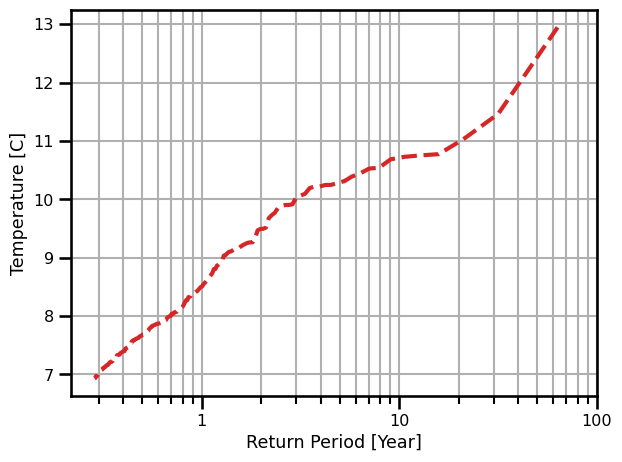

In [141]:
fig, ax = plt.subplots()

ax.plot(
    return_periods["return period"],
    return_periods["t2m"], 
    linestyle="--", linewidth=3, color="tab:red"
    
)
ax.set(
    xlabel="Return Period [Year]",
    ylabel="Temperature [C]",
    xscale="log",
    xticks=[1.0, 10.0, 100.0]
    
)

# format log scale labels
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)

plt.grid(which="both", visible=True)

plt.tight_layout()
plt.show()